#COMPUTER VISION AND PATTERN RECOGNITION PROJECT 1

Kaan Egemen Sen


In [ ]:
import numpy as np
from scipy.ndimage import convolve
from PIL import Image, ImageOps
import math

def generate_gaussian_kernel(kernel_size, sigma):
    kernel = np.fromfunction(lambda x, y: (1 / (2 * np.pi * sigma ** 2)) * np.exp(-((x - (kernel_size // 2)) ** 2 + (y - (kernel_size // 2)) ** 2) / (2 * sigma ** 2)), (kernel_size, kernel_size))
    kernel /= np.sum(kernel)
    return kernel

def apply_convolution(image, kernel):

    if len(image.shape) == 2:  # Grayscale image
        output = convolve(image, kernel, mode='reflect')
    else:  # Color image
        channels = image.shape[2]
        output = np.zeros_like(image)
        for c in range(channels):
            output[:, :, c] = convolve(image[:, :, c], kernel, mode='reflect')

    return output

def compute_gradient_magnitude(blurred_image):
    blurred_array = np.array(blurred_image, dtype=np.float32)

    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Ix = np.zeros_like(blurred_array)
    Iy = np.zeros_like(blurred_array)
    for i in range(1, blurred_array.shape[0] - 1):
        for j in range(1, blurred_array.shape[1] - 1):
            Ix[i, j] = (Gx * blurred_array[i-1:i+2, j-1:j+2]).sum()
            Iy[i, j] = (Gy * blurred_array[i-1:i+2, j-1:j+2]).sum()

    gradient_magnitude = np.sqrt(Ix**2 + Iy**2)
    gradient_magnitude = 255 * (gradient_magnitude / np.max(gradient_magnitude))
    gradient_magnitude = gradient_magnitude.astype(np.uint8)
    return gradient_magnitude
    # return Image.fromarray(gradient_magnitude)

def hysteresis_threshold(gradient_image, low_threshold, high_threshold):
    gradient_array = np.array(gradient_image, dtype=np.uint8)
    hysteresis_image = np.zeros_like(gradient_array)
    visited = np.zeros_like(gradient_array)

    strong_pixels = []
    weak_pixels = []

    # Determine strong and weak pixels based on thresholds
    high_pixels = np.where(gradient_array >= high_threshold)
    hysteresis_image[high_pixels] = 255
    strong_pixels = list(zip(high_pixels[0], high_pixels[1]))

    low_pixels = np.where((gradient_array >= low_threshold) & (gradient_array < high_threshold))
    weak_pixels = list(zip(low_pixels[0], low_pixels[1]))

    # Perform hysteresis thresholding
    while weak_pixels:
        current_pixel = weak_pixels.pop()
        visited[current_pixel] = 255

        i, j = current_pixel
        i_start = max(i - 1, 0)
        i_end = min(i + 2, hysteresis_image.shape[0])
        j_start = max(j - 1, 0)
        j_end = min(j + 2, hysteresis_image.shape[1])
        neighbors = hysteresis_image[i_start:i_end, j_start:j_end]

        if np.any(neighbors >= high_threshold):
            hysteresis_image[i, j] = 255

            for px in np.argwhere((neighbors >= low_threshold) & (neighbors < high_threshold)):
                px_i, px_j = px[0] + (i_start), px[1] + (j_start)
                if visited[px_i, px_j] != 255:
                    weak_pixels.append((px_i, px_j))

    return Image.fromarray(hysteresis_image)

In [ ]:

def hough_transform(img):
    # Get image dimensions
    Ny = img.shape[0]
    Nx = img.shape[1]

    # Max distance is diagonal one
    Maxdist = int(np.round(np.sqrt(Nx ** 2 + Ny ** 2)))
    # Theta in range from -90 to 90 degrees
    thetas = np.deg2rad(np.arange(-90, 90,0.5))
    # Range of radius
    rs = np.linspace(-Maxdist, Maxdist, 2 * Maxdist)
    accumulator = np.zeros((2 * Maxdist, len(thetas)))

    for y in range(Ny):
        for x in range(Nx):
            # Check if it is an edge pixel
            if np.any(img[y, x]):
            # Map edge pixel to hough space
                for k in range(len(thetas)):
                    # Calculate space parameter
                    r = x * np.cos(thetas[k]) + y * np.sin(thetas[k])

                    # Update the accumulator
                    accumulator[int(r) + Maxdist, k] += 1

    return accumulator, thetas, rs

def extract_lines(acc, theta, rho, threshold):
    # Find indices of cells in accumulator array above threshold
    indices = np.argwhere(acc >= threshold)

    # Extract rho and theta values for detected lines
    detected_lines = []
    for index in indices:
        rho_index, theta_index = index
        detected_rho = rho[rho_index]
        detected_theta = theta[theta_index]
        detected_lines.append((detected_rho, detected_theta))

    return detected_lines





def draw_lines(img, houghLines, color=[0, 255, 0], thickness=2):
    image = img.copy()  # Make a copy of the image to avoid modifying the original image
    for rho, theta in houghLines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(image, (x1, y1), (x2, y2), color, thickness)

    return image

def draw_points(img, points, color=[0,0,0], radius = 8):
    image = img.copy()
    for p in points:
        cv2.circle(image, (int(p[0]), int(p[1])), radius=0, color=color, thickness=radius)

    return image


In [ ]:
# Example usage:
# Load input image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
img = cv2.imread("/content/house1.png")

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_image = np.array(img_rgb, dtype=np.float32)
img_r,img_g,img_b = input_image[:,:,0],input_image[:,:,1],input_image[:,:,2]

low_threshold = 10
high_threshold = 30
hysteresis_g = hysteresis_threshold(img_g, low_threshold, high_threshold)


# Gradient magnitude
# green clearly gives necessary edges
gradient_image = compute_gradient_magnitude(hysteresis_g)

# Hysteresis
hysteresis_image = hysteresis_threshold(gradient_image, 10, 250)

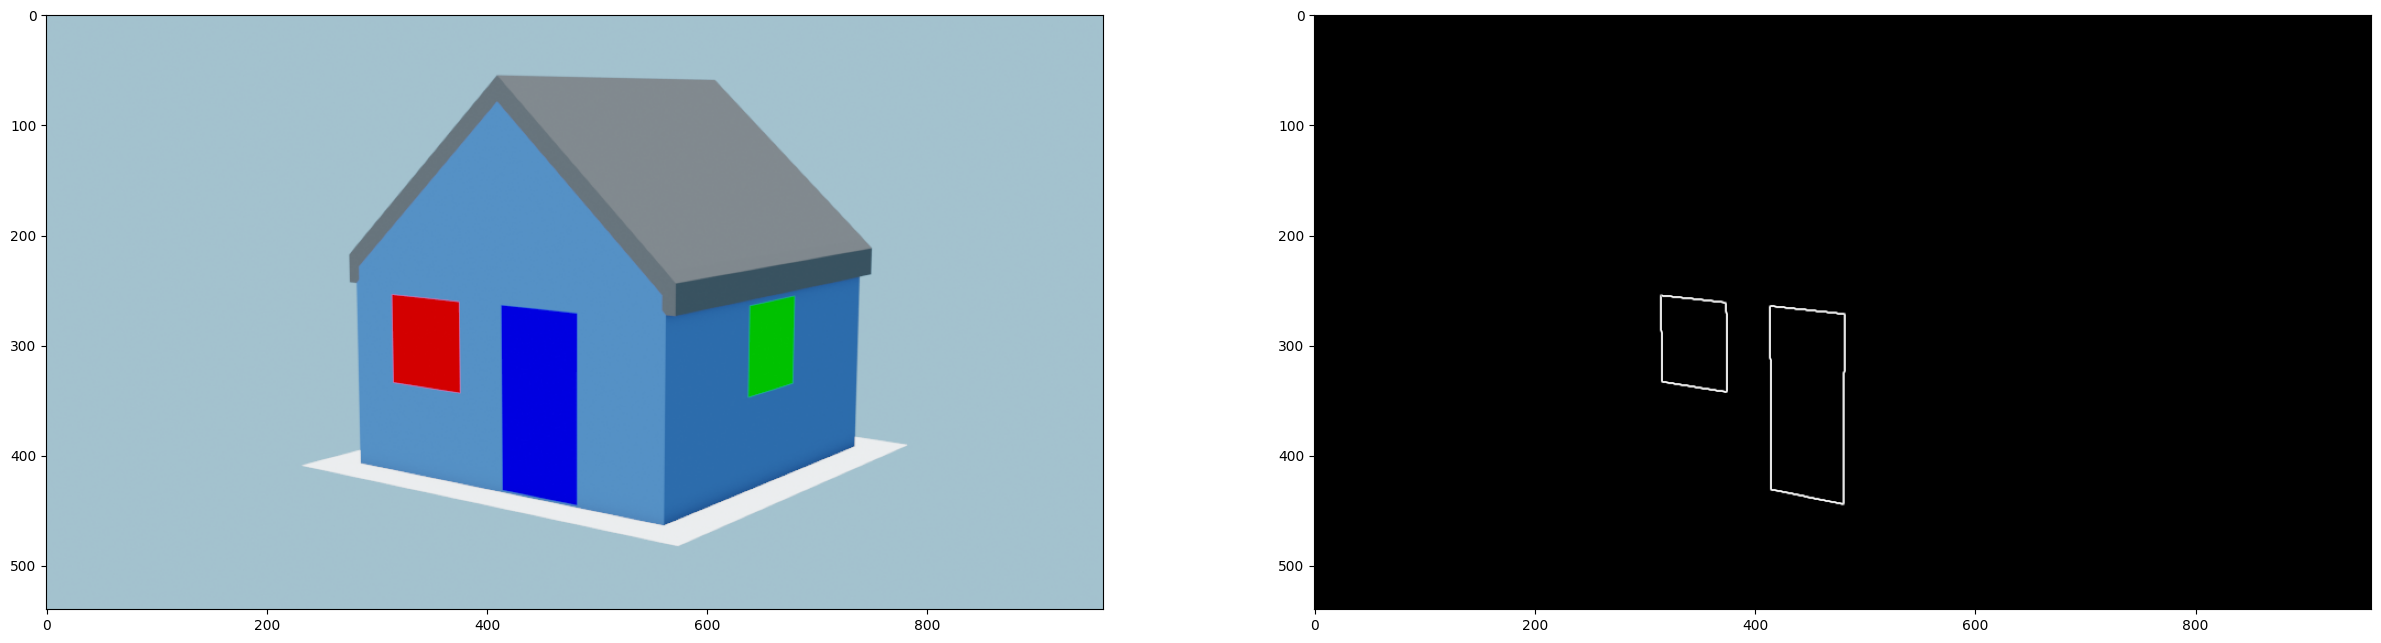

In [ ]:
plt.figure(figsize = (30,20))
plt.subplot(121)
plt.imshow(img_rgb)
plt.subplot(122)
plt.imshow(gradient_image)
plt.show()

In [ ]:
hysteresis_array = np.array(gradient_image)
acc,theta,rho=hough_transform(hysteresis_array)

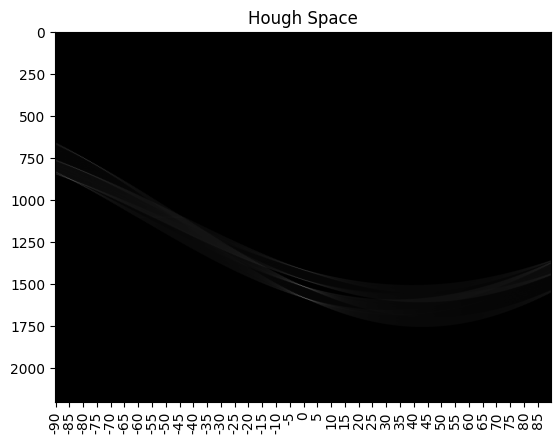

In [ ]:
plt.title('Hough Space')
plt.imshow(acc,aspect='auto')
plt.set_cmap('gray')
plt.xticks(range(0,360,10),range(-90,90,5),rotation=90)
plt.show();

#Using hough transform to draw lines

In [ ]:
# select 20 angles where lines are most likely to pass
hough_angles = sum(np.power(acc,15))
k = 20
indices = []
for i in range(k) :
  index_min = np.argmax(hough_angles)
  indices += [index_min]
  hough_angles[index_min] = 0

[i/2 for i in indices]

[90.0,
 90.5,
 89.5,
 91.0,
 89.0,
 6.0,
 5.5,
 91.5,
 5.0,
 88.5,
 6.5,
 92.0,
 88.0,
 4.5,
 87.5,
 7.0,
 92.5,
 12.5,
 12.0,
 11.0]

In [ ]:
l_indices = [10,16,24]
r_indices = [180, 181]
new_indices = l_indices+r_indices #these are the angles of our house in this view. as we see from the hough space.

In [ ]:
#masking the accumulator to get only lines of that angle
mask = np.zeros_like(acc)
mask[:,l_indices] = 1
acc2 = acc*mask

mask = np.zeros_like(acc)
mask[:,r_indices] = 1
acc3 = acc*mask

#get the perpendicular lines separately too so that we can easily get the corners
mask = np.zeros_like(acc)
mask[:,180] = 1
acc4 = acc*mask


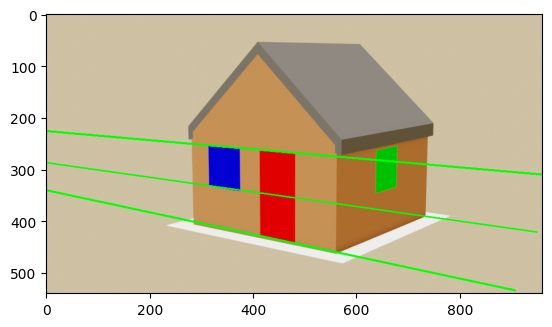

In [ ]:
lines_l=extract_lines(acc2,theta,rho,67)
img_lines=draw_lines(img,lines_l)
plt.imshow(img_lines);

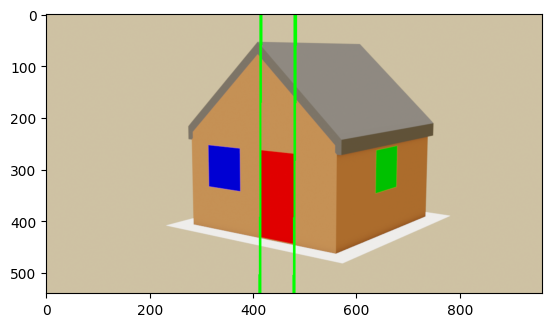

In [ ]:
# Display the image with the detected lines
lines_r=extract_lines(acc3, theta,rho,110)
img_lines=draw_lines(img,lines_r)
plt.imshow(img_lines);

In [ ]:
lines_r

[(414.68832348932324, 0.0),
 (415.6887778282601, 0.0),
 (417.68968650613374, 0.008726646259971648),
 (480.71830985915517, 0.0),
 (481.718764198092, 0.0),
 (483.71967287596567, 0.008726646259971648),
 (484.7201272149025, 0.008726646259971648)]

[(315.64334393457534, 0.0),
 (374.6701499318492, 0.0),
 (375.67060427078604, 0.0),
 (414.68832348932324, 0.0),
 (415.6887778282601, 0.0),
 (480.71830985915517, 0.0),
 (481.718764198092, 0.0)]

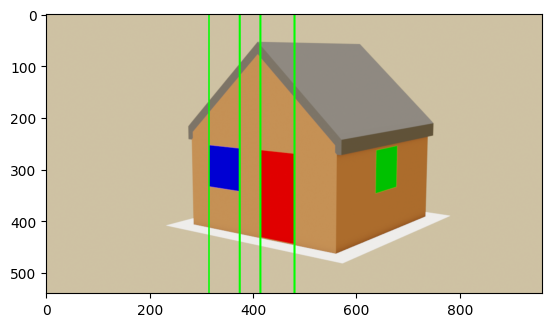

In [ ]:
lines_perp=extract_lines(acc4, theta,rho,60)
img_lines=draw_lines(img,lines_perp)
plt.imshow(img_lines);
lines_perp

In [ ]:
#simplify lines
new_lines = []
lines_l.sort(key = lambda a: a[1])
for l in lines_l:
  #pick similar lines
  lis = [li for li in lines_l if l[1] == li[1] and l[0]+5>li[0]>l[0]-5]
  rhos = [_l[0] for _l in lis]
  new_lines += [(sum(rhos)/len(lis),l[1])]

new_lines_l = list(dict.fromkeys(new_lines))
new_lines = []
lines_r.sort(key = lambda a: a[1])
for l in lines_r:
  #pick similar lines
  lis = [li for li in lines_r if l[1] == li[1] and l[0]+5>li[0]>l[0]-5]
  rhos = [_l[0] for _l in lis]
  new_lines += [(sum(rhos)/len(lis),l[1])]

new_lines_r = list(dict.fromkeys(new_lines))

new_lines_perp = list(dict.fromkeys(new_lines))
new_lines_l,new_lines_r

([(-227.1031349386642, -1.4835298641951802),
  (-285.62971376646965, -1.4311699866353502),
  (-334.15174920490676, -1.361356816555577)],
 [(415.18855065879166, 0.0),
  (481.2185370286236, 0.0),
  (417.68968650613374, 0.008726646259971648),
  (484.2199000454341, 0.008726646259971648)])

In [ ]:
new_lines_r.remove((415.18855065879166, 0.0)) #this slips into the calculations

In [ ]:
PL0 = []
PL1 = []
for o in new_lines_l:
    rho,theta = o
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    PL0 += [[x0,y0]]

    x1 = x0 +  -b
    y1 = y0 +   a
    PL1 += [[x1,y1]]
PL0 = np.array(PL0)
PL1 = np.array(PL1)

In [ ]:
PR0 = []
PR1 = []
for o in new_lines_r:
    rho,theta = o
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    PR0 += [[x0,y0]]

    x1 = x0 +  -b
    y1 = y0 +   a
    PR1 += [[x1,y1]]
PR0 = np.array(PR0)
PR1 = np.array(PR1)

In [ ]:
def intersect(P0,P1):
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.

    Got this from:
    https://stackoverflow.com/questions/52088966/nearest-intersection-point-to-many-lines-in-python
    """
    # generate all line direction vectors
    n = (P1-P0)/np.linalg.norm(P1-P0,axis=1)[:,np.newaxis] # normalized

    # generate the array of all projectors
    projs = np.eye(n.shape[1]) - n[:,:,np.newaxis]*n[:,np.newaxis]  # I - n*n.T
    # see fig. 1

    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P0[:,:,np.newaxis]).sum(axis=0)

    # solve the least squares problem for the
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q,rcond=None)[0]

    return p

In [ ]:
P1=intersect(PL0,PL1)
P2=intersect(PR0,PR1)
print(P1)
print(P2)

[[-899.97597175]
 [ 153.84593282]]
[[  481.21853703]
 [-3465.91387055]]


In [ ]:
#turn the vanishing points into homogenous coordinates
P1 = np.array([[P1[1],P1[0],1]],dtype = np.float64)
P2 = np.array([[P2[1],P2[0],1]],dtype = np.float64)

<ipython-input-62-bdf00ef091c5>:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  P1 = np.array([[P1[1],P1[0],1]],dtype = np.float64)
<ipython-input-62-bdf00ef091c5>:3: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  P2 = np.array([[P2[1],P2[0],1]],dtype = np.float64)


In [ ]:
#find projection of line at infinity
lin_inf = np.cross(P1,P2)
lin_inf

array([[-1.38119451e+03, -3.61975980e+03, -3.04520569e+06]])

In [ ]:
#define the transformation matrix as shown on slides
transformation_matrix= np.array([[1,0,0],[0,1,0]],dtype=np.float64)
transformation_matrix = np.vstack((transformation_matrix,lin_inf))
transformation_matrix

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.38119451e+03, -3.61975980e+03, -3.04520569e+06]])

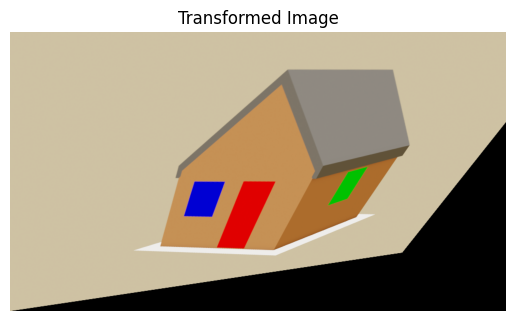

In [ ]:
width, height = img.shape[1], img.shape[0]

#define a simple affine_matrix to scale
affine_matrix =  np.array([[1,0,0],[0,1,0],[0,0,-2.0e-7]],dtype=np.float64)

transformed_image = cv2.warpPerspective(img, affine_matrix@transformation_matrix, (width, height))

# Display the transformed image
plt.imshow(transformed_image)
plt.title("Transformed Image")
plt.axis('off')
plt.show()

In [ ]:
points = []
#intersections, we want to get corners from these
for l1 in lines_l:
  for l2 in lines_perp:
    rho,theta = l1
    a = np.cos(theta)
    b = np.sin(theta)
    m = a/b
    x0 = a * rho
    y0 = b * rho

    x_t = l2[0]
    param = (x_t-x0)/(-b)

    points += [(x_t,y0 + param*a)]


In [ ]:
[(i,points[i]) for i in range(len(points))]

[(0, (315.64334393457534, 256.08798428739493)),
 (1, (374.6701499318492, 261.2521606563004)),
 (2, (375.67060427078604, 261.3396890693327)),
 (3, (414.68832348932324, 264.7532971775923)),
 (4, (415.6887778282601, 264.84082559062455)),
 (5, (480.71830985915517, 270.5301724377238)),
 (6, (481.718764198092, 270.61770085075614)),
 (7, (315.64334393457534, 255.08370837541378)),
 (8, (374.6701499318492, 260.24788474431926)),
 (9, (375.67060427078604, 260.3354131573516)),
 (10, (414.68832348932324, 263.74902126561113)),
 (11, (415.6887778282601, 263.83654967864345)),
 (12, (480.71830985915517, 269.5258965257427)),
 (13, (481.718764198092, 269.61342493877504)),
 (14, (315.64334393457534, 332.797539516801)),
 (15, (374.6701499318492, 341.093216101474)),
 (16, (375.67060427078604, 341.2338207893498)),
 (17, (414.68832348932324, 346.7174036165066)),
 (18, (415.6887778282601, 346.8580083043824)),
 (19, (480.71830985915517, 355.9973130163103)),
 (20, (481.718764198092, 356.1379177041861)),
 (21, (3

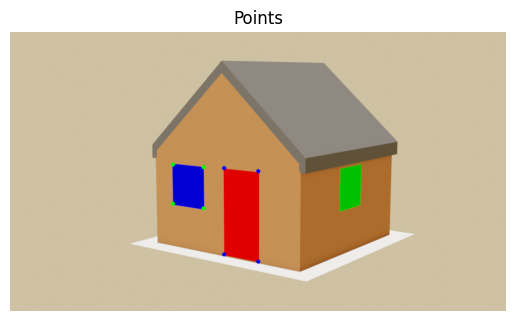

In [ ]:
#selected corners on green we have window and on blue the door
window_ind = [0,1,14,15]
door_ind = [10,24,26,12]
window_p = [points[i] for i in range(len(points)) if i in window_ind]
door_p = [points[i] for i in range(len(points)) if i in door_ind]
w_point_image = draw_points(img,window_p,color=(0,255,0))
point_image = draw_points(w_point_image,door_p,color=(0,0,255))
plt.imshow(point_image)
plt.title("Points")
plt.axis('off')
plt.show()

In [ ]:
#rescales back to homogenous coordinates
def hom(v):
  return v/v[2]

fixed_w = [hom(affine_matrix@transformation_matrix@np.array([p[0],p[1],1])) for p in window_p]
fixed_d = [hom(affine_matrix@transformation_matrix@np.array([p[0],p[1],1])) for p in door_p]
fixed_w,fixed_d

([array([358.02266315, 290.47120396,   1.        ]),
  array([415.52745982, 289.74138108,   1.        ]),
  array([336.80711057, 355.11148846,   1.        ]),
  array([390.49507569, 355.49995446,   1.        ])],
 [array([453.44132051, 288.39660466,   1.        ]),
  array([513.06279564, 287.66058445,   1.        ]),
  array([400.62975088, 415.68610682,   1.        ]),
  array([452.01874526, 417.78230633,   1.        ])])

In [ ]:
#herons formula to calculate area
def heron(a,b,c):
  a = np.array([a[0],a[1]])
  b = np.array([b[0],b[1]])
  c = np.array([c[0],c[1]])
  ab = np.linalg.norm(a-b)
  ac = np.linalg.norm(a-c)
  bc = np.linalg.norm(b-c)
  s=(ab+ac+bc)/2
  return np.sqrt(s*(s-ab)*(s-ac)*(s-bc))

#apply heron twice
def four_point_area(a,b,c,d):
  return heron(a,b,c) + heron(b,c,d)

wa = four_point_area(fixed_w[0],fixed_w[1],fixed_w[2],fixed_w[3])
da = four_point_area(fixed_d[0],fixed_d[1],fixed_d[2],fixed_d[3])

print(f"if window is 1m^2 then the door is {da/wa}m^2")

if window is 1m^2 then the door is 1.9836339771786775m^2


In [ ]:
owa = four_point_area(window_p[0],window_p[1],window_p[2],window_p[3])
oda = four_point_area(door_p[0],door_p[1],door_p[2],door_p[3])

print(f"originally if window was 1m^2 door would have been {oda/owa}m^2")

originally if window was 1m^2 door would have been 2.4388291911834212m^2
